<a href="https://colab.research.google.com/github/Testeh69/FreeCodeCamp-ML/blob/main/fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.6/528.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.0/441.0 kB 39.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.14.0-dev20230513


In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2023-05-13 11:17:46--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.03s   

2023-05-13 11:17:46 (9.85 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2023-05-13 11:17:46--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

In [ ]:
train_dataframe = pd.read_csv(train_file_path, sep = '\t', header = None , names = ["type","msg"]) #\t utiliser une tabulation comme séparateur sinon une erreur se produit, supprime le name des colonnes header = None et rename the label of the datafram into type and msg
test_dataframe = pd.read_csv(test_file_path, sep = '\t', header = None, names = ["type","msg"])

In [ ]:
train_dataframe.dropna()
test_dataframe.dropna()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?
...,...,...
1387,ham,true dear..i sat to pray evening and felt so.s...
1388,ham,"what will we do in the shower, baby?"
1389,ham,where are you ? what are you doing ? are yuou ...
1390,spam,ur cash-balance is currently 500 pounds - to m...


In [ ]:
train_dataframe.head()

,type,msg
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [ ]:
test_dataframe.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [ ]:
#Transform the type into number 0 and 1
train_dataframe["type"] = pd.factorize(train_dataframe["type"])[0]
test_dataframe["type"] = pd.factorize(test_dataframe["type"])[0]
test_dataframe.head()

,type,msg
0,0,i am in hospital da. . i will return home in e...
1,0,"not much, just some textin'. how bout you?"
2,0,i probably won't eat at all today. i think i'm...
3,0,don‘t give a flying monkeys wot they think and...
4,0,who are you seeing?


In [ ]:
train_dataset_label = train_dataframe["type"].values
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_dataframe["msg"].values, train_dataset_label)
)


In [ ]:
test_dataset_label = test_dataframe["type"].values
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_dataframe["msg"].values, test_dataset_label)
)

In [ ]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Transform each word into an integer number then fit the train_dataset into the textvecorization layer

In [ ]:
from keras.layers.experimental.preprocessing import TextVectorization


vec = TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

vec.adapt(train_dataset.map(lambda text, label:text))


In [ ]:
vocab = np.array(vec.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'to', 'i', 'you', 'a', 'the', 'u', 'and', 'in', 'is',
       'me', 'my', 'for', 'your', 'of', 'it', 'call', 'have', 'on'],
      dtype='<U15')

In [ ]:
model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(
        len(vec.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
131/131 [==============================] - 512s 4s/step - loss: 0.5983 - accuracy: 0.8660 - val_loss: 0.4755 - val_accuracy: 0.8604
Epoch 2/10
131/131 [==============================] - 477s 4s/step - loss: 0.3473 - accuracy: 0.8660 - val_loss: 0.1999 - val_accuracy: 0.8604
Epoch 3/10
131/131 [==============================] - 499s 4s/step - loss: 0.1370 - accuracy: 0.9471 - val_loss: 0.1046 - val_accuracy: 0.9719
Epoch 4/10
131/131 [==============================] - 480s 4s/step - loss: 0.0826 - accuracy: 0.9816 - val_loss: 0.0724 - val_accuracy: 0.9812
Epoch 5/10
131/131 [==============================] - 496s 4s/step - loss: 0.0612 - accuracy: 0.9864 - val_loss: 0.0662 - val_accuracy: 0.9865
Epoch 6/10
131/131 [==============================] - 482s 4s/step - loss: 0.0501 - accuracy: 0.9880 - val_loss: 0.0600 - val_accuracy: 0.9875
Epoch 7/10
131/131 [==============================] - 476s 4s/step - loss: 0.0419 - accuracy: 0.9911 - val_loss: 0.0573 - val_accuracy: 0.9896

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

44/44 [==============================] - 32s 727ms/step - loss: 0.0633 - accuracy: 0.9849


In [ ]:
print("test loss:",test_loss)
print("test accuracy:", test_acc, "%")

test loss: 0.06331337243318558
test accuracy: 0.9849137663841248 %


In [ ]:
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


(0.0, 0.6270445617847145)

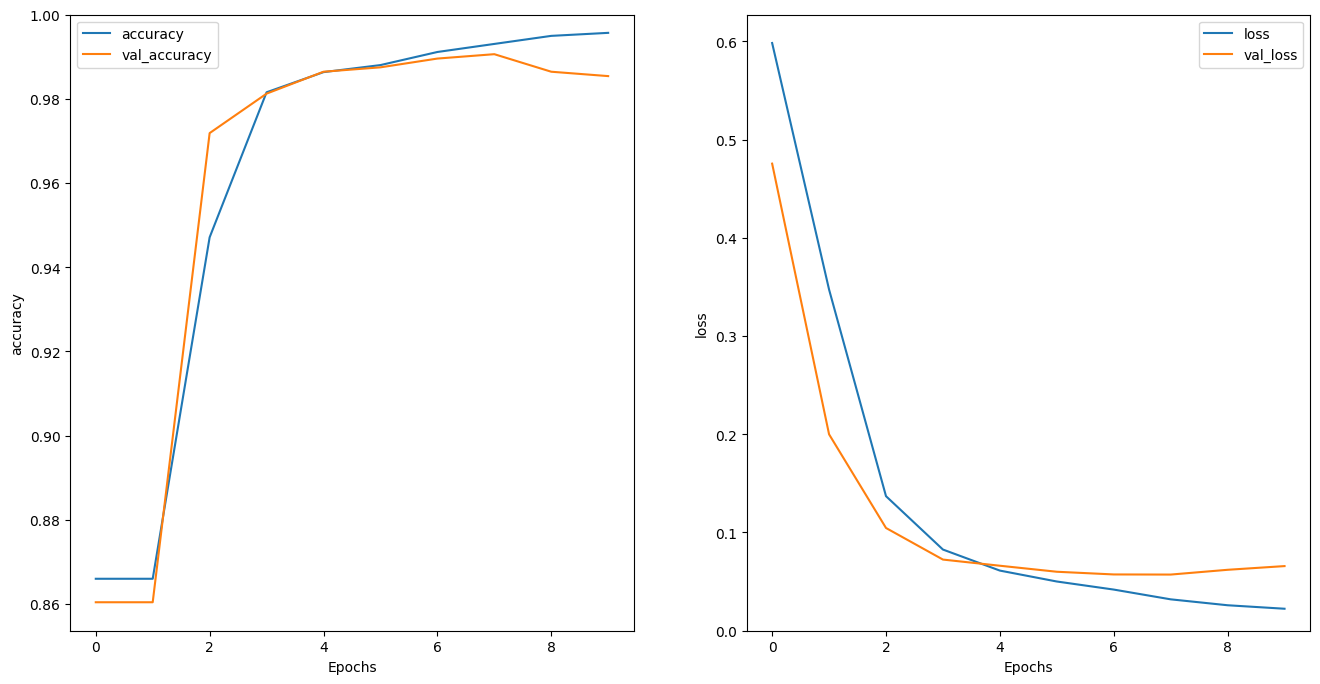

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  ps = model.predict([pred_text])
  variable_predict = ps[0][0]
  prediction = [variable_predict, "ham" if variable_predict<0.5 else "spam"]
  return (prediction)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 463ms/step
[-6.051252, 'ham']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 245ms/step
You passed the challenge. Great job!
